# Pycaret Models

Use Pycaret to train models for comparison. Ultimately the idea is the following.

1. Have a new way to preprocess the data.
2. Train Keras models with this new data.
3. Ensemble the Keras models using the two different data preprocessing methods.


In [1]:
import gc

import logging
from typing import Tuple

import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from pycaret.classification import *

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

from keras import callbacks
from keras import optimizers

import matplotlib.pyplot as plt

2023-02-28 17:45:48.135494: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-28 17:45:48.639232: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-28 17:45:48.639278: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-28 17:45:48.639284: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [2]:
logging.getLogger('matplotlib.font_manager').setLevel(logging.ERROR)

## Load Source Data

In [3]:
# load the source training set
df_source = pd.read_csv('data/train.csv.gz', compression='gzip', index_col=1)

print(df_source.shape)
with pd.option_context('display.max_columns', None):
    display(df_source.head(3))

(13174211, 19)


,session_id,elapsed_time,event_name,name,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,text,fqid,room_fqid,text_fqid,fullscreen,hq,music,level_group
index,,,,,,,,,,,,,,,,,,,
0,20090312431273200,0,cutscene_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,undefined,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,NaN,NaN,NaN,0-4
1,20090312431273200,1323,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,"Whatcha doing over there, Jo?",gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4
2,20090312431273200,831,person_click,basic,0,NaN,-413.991405,-159.314686,380.0,494.0,NaN,Just talking to Teddy.,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,NaN,NaN,NaN,0-4


In [4]:
df_source.describe()

,session_id,elapsed_time,level,page,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,hover_duration,fullscreen,hq,music
count,1.317421e+07,1.317421e+07,1.317421e+07,284746.000000,1.213797e+07,1.213797e+07,1.213797e+07,1.213797e+07,1.000737e+06,0.0,0.0,0.0
mean,2.113413e+16,3.846817e+06,1.219194e+01,3.157930,-5.493615e+01,-1.162997e+02,4.581144e+02,3.852363e+02,3.186237e+03,NaN,NaN,NaN
std,5.665220e+14,2.701387e+07,6.499188e+00,2.064042,5.201468e+02,2.185912e+02,2.472144e+02,1.292879e+02,3.692265e+05,NaN,NaN,NaN
min,2.009031e+16,0.000000e+00,0.000000e+00,0.000000,-1.992355e+03,-9.181587e+02,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,NaN
25%,2.101031e+16,4.394300e+05,6.000000e+00,1.000000,-3.529376e+02,-2.128361e+02,2.690000e+02,3.040000e+02,1.000000e+02,NaN,NaN,NaN
50%,2.104022e+16,1.013425e+06,1.300000e+01,3.000000,-1.116317e+01,-9.778151e+01,4.470000e+02,3.970000e+02,4.180000e+02,NaN,NaN,NaN
75%,2.110051e+16,1.740050e+06,1.800000e+01,5.000000,2.963618e+02,2.268531e+01,6.630000e+02,4.710000e+02,1.266000e+03,NaN,NaN,NaN
max,2.210022e+16,1.749293e+09,2.200000e+01,6.000000,1.261774e+03,5.436164e+02,1.916000e+03,1.439000e+03,2.199078e+08,NaN,NaN,NaN


In [5]:
# load the source training labels
df_source_labels = pd.read_csv('data/train_labels.csv')

print(df_source_labels.shape)
with pd.option_context('display.max_columns', None):
    display(df_source_labels.head(3))

(212022, 2)


,session_id,correct
0,20090312431273200_q1,1
1,20090312433251036_q1,0
2,20090314121766812_q1,1


## Functions

### Functions to prepare the data

In [6]:
def map_question_to_level_group(question_number):
    """
    Maps the question number to the level group.

    Parameters
    ----------
    question_number : int
        The question number.

    Returns
    -------
    str
        The level group.
    """
    if question_number in [1, 2, 3]:
        return '0-4'
    elif question_number in [4, 5, 6, 7, 8, 9, 10, 11, 12, 13]:
        return '5-12'
    elif question_number in [14, 15, 16, 17, 18]:
        return '13-22'
    else:
        return None

def prepare_label_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the label dataset and add columns for the level group 
    and the question number.

    Parameters
    ----------
    data : pd.DataFrame
        The label dataset.

    Returns
    -------
    pd.DataFrame
        The prepared label dataset.
    """
    # add the columns to determine the level group
    df_labels = data \
        .rename(columns={'session_id': 'id'}) \
        .assign(session_id=lambda df: df['id'].str.split('_').str[0].astype(int)) \
        .assign(question_id=lambda df: df['id'].str.split('_').str[1]) \
        .assign(question_num=lambda df: df['question_id'].str[1:].astype(int)) \
        [['session_id', 'question_num', 'correct']]
    
    # add the level group column
    df_labels['level_group'] = df_labels['question_num'].apply(map_question_to_level_group) 

        
    return df_labels

In [7]:
def prepare_main_dataset(data : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the main dataset by removing duplicates and removing 
    columns that are not needed.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared main dataset.
    """
    empty_columns = ['fullscreen', 'hq', 'music', 'page', 'hover_duration']

    df_main = data \
        .drop_duplicates() \
        .reset_index(drop=True) \
        .drop(empty_columns, axis=1) \
        .drop('text', axis=1)

    return df_main

### Functions to create datasets

### Functions for Model Training

In [8]:
def plot_loss(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the loss and validation loss.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for loss
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['loss'])
    
    if ('val_loss' in history.history):
        plt.plot(epochs, history.history['val_loss'])
        plt.legend(['Training loss', 'Validation loss'], loc='upper left')
        plt.title('Training and validation loss')
    else:
        plt.title('Training loss')

    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.show()

In [9]:
def plot_accuracy(history: callbacks.History, figsize: Tuple[int, int] = (5, 3)) -> None:
    """
    Plot the accuracy and validation accuracy.

    Parameters
    ----------
    history : keras.callbacks.History
        The history of the model training.
    """
    epochs = range(1, len(history.history['accuracy']) + 1)

    # summarize history for accuracy
    plt.figure(figsize=figsize)
    plt.plot(epochs, history.history['accuracy'])

    if ('val_accuracy' in history.history):
        plt.plot(epochs, history.history['val_accuracy'])
        plt.legend(['Training acc', 'Validation acc'], loc='upper left')
        plt.title('Training and validation accuracy')
    else:
        plt.title('Training accuracy')

    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.show()

In [10]:
def optimize_f1(y_true: np.ndarray, y_score: np.ndarray, average:str='macro') -> Tuple[float, float, float]:
    """
    Optimize the F1 score.

    Parameters
    ----------
    y_true : np.ndarray
        The true labels.
    y_score : np.ndarray
        The predicted labels.
    average : str, optional
        The average method to use for F1, by default 'macro'

    Returns
    -------
    Tuple[float, float, float]
        The optimized threshold, precision, and recall.
    """
    best_f1 = 0
    best_threshold = 0
    best_precision = 0
    best_recall = 0

    for threshold in np.arange(0, 1, 0.01):
        y_pred = (y_score > threshold).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=average, zero_division=1)

        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
            best_precision = precision
            best_recall = recall

    return best_threshold, best_precision, best_recall

In [11]:
def train_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None) -> callbacks.History:
    """
    Train the keras model based on the parameters.

    Parameters
    ----------
    model : keras.models
        The model to train.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    
    Returns
    -------
    keras.callbacks.History
        The history of the training.
    """
    # compile the model
    model.compile(
        optimizer=optimizer,
        loss=loss,
        metrics=metrics)
    
    # fit the model
    history = model.fit(
        x=X_train,
        y=y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        class_weight=class_weight)
    
    return history

In [12]:
def test_model(
        model,
        history: callbacks.History,
        X_test: np.ndarray,
        y_test: np.ndarray,
        f1_average:str='macro') -> float:
    """
    Test the model based on the test data.

    Parameters
    ----------
    model : keras.models
        The model to test.
    history : keras.callbacks.History
        The history of the training.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    
    plot_loss(history)
    plot_accuracy(history)

    y_test_score = model.predict(X_test)
    threshold, _, _ = optimize_f1(y_test, y_test_score, average=f1_average)

    print(classification_report(y_test, y_test_score > threshold))
    print(f'Optimized threshold for best F1: {threshold:.2f}')

    gc.collect()

    return threshold

In [13]:
def train_and_test_model(
        model,
        X_train: np.ndarray,
        y_train: np.ndarray,
        X_val : np.ndarray,
        y_val: np.ndarray,
        X_test: np.ndarray,
        y_test: np.ndarray,
        epochs: int,
        batch_size: int,
        optimizer,
        loss: str,
        metrics: list,
        class_weight: dict=None,
        f1_average:str='macro') -> float:
    """
    Train and test the model.

    Parameters
    ----------
    model : keras.models
        The model to train and test.
    X_train : np.ndarray
        The training data.
    y_train : np.ndarray
        The training labels.
    X_val : np.ndarray
        The validation data.
    y_val : np.ndarray
        The validation labels.
    X_test : np.ndarray
        The test data.
    y_test : np.ndarray
        The test labels.
    epochs : int
        The number of epochs.
    batch_size : int
        The batch size.
    optimizer : keras.optimizers
        The optimizer.
    loss : str
        The loss function.
    metrics : list
        The metrics.
    class_weight : dict, optional
        The class weights, by default None
    f1_average : str, optional
        The average method to use for F1, by default 'macro'

    Returns
    -------
    float
        The optimized threshold for the best F1 score.
    """
    history = train_model(
        model=model,
        X_train=X_train,
        y_train=y_train,
        X_val=X_val,
        y_val=y_val,
        epochs=epochs,
        batch_size=batch_size,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics,
        class_weight=class_weight)
    
    gc.collect()

    return test_model(model, history, X_test, y_test, f1_average=f1_average)

In [14]:
def global_train_model(model,
                       epochs: int,
                       batch_size: int,
                       optimizer,
                       loss: str,
                       metrics: list,
                       class_weight: dict=None,
                       f1_average:str='macro') -> float:
        """
        Train the model using the global data.

        Parameters
        ----------
        model : keras.models
                The model to train.
        epochs : int
                The number of epochs.
        batch_size : int
                The batch size.
        optimizer : keras.optimizers
                The optimizer.
        loss : str
                The loss function.
        metrics : list
                The metrics.
        class_weight : dict
                The class weights.
        f1_average : str
                The average method for the F1 score.

        Returns
        -------
        float
                The optimized threshold for the best F1 score.
        """
        global X_train
        global y_train
        global X_val
        global y_val
        global X_test
        global y_test

        return train_and_test_model(
                model=model,
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
                X_test=X_test,
                y_test=y_test,
                epochs=epochs,
                batch_size=batch_size,
                optimizer=optimizer,
                loss=loss,
                metrics=metrics,
                class_weight=class_weight,
                f1_average=f1_average)

## Pre-process Data

In [15]:
# prepare the main dataset
df_source = prepare_main_dataset(df_source)

with pd.option_context('display.max_columns', None):
    print(df_source.shape)
    display(df_source.head(3))  

(13173445, 13)


,session_id,elapsed_time,event_name,name,level,room_coor_x,room_coor_y,screen_coor_x,screen_coor_y,fqid,room_fqid,text_fqid,level_group
0,20090312431273200,0,cutscene_click,basic,0,-413.991405,-159.314686,380.0,494.0,intro,tunic.historicalsociety.closet,tunic.historicalsociety.closet.intro,0-4
1,20090312431273200,1323,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4
2,20090312431273200,831,person_click,basic,0,-413.991405,-159.314686,380.0,494.0,gramps,tunic.historicalsociety.closet,tunic.historicalsociety.closet.gramps.intro_0_...,0-4


In [16]:
# prepare the label dataset
df_source_labels = prepare_label_dataset(df_source_labels)

with pd.option_context('display.max_columns', None):
    display(df_source_labels.sample(n=3, random_state=51))

,session_id,question_num,correct,level_group
21476,22010116250792520,2,1,0-4
84068,21000111433937450,8,1,5-12
171219,21040510125933256,15,0,13-22


In [17]:
gc.collect()

50

## Feature Engineering

In [18]:
def minimal_features(data : pd.DataFrame) -> pd.DataFrame:
    """
    Creates a minimal feature set.

    Parameters
    ----------
    data : pd.DataFrame
        The dataset.

    Returns
    -------
    pd.DataFrame
        The dataset with the minimal feature set.
    """
    # select the columns that are used for the minimal feature set
    source_columns = [
        'session_id',
        'elapsed_time',
        'room_coor_x',
        'room_coor_y',
        'screen_coor_x',
        'screen_coor_y',
        'level_group',
    ]

    df_data = data[source_columns]

    # summarize the data
    df_summary = df_data \
        .groupby([
            'session_id',
            'level_group',
        ]) \
        .agg({
            'elapsed_time': ['sum'],
            #'elapsed_time': ['min', 'max', 'mean', 'std', 'median', 'skew'],
        }) \
        .reset_index() \
        .droplevel(1, axis=1)

    return df_summary

df_minimal = minimal_features(df_source)

with pd.option_context('display.max_columns', None):
    print(df_minimal.shape)
    display(df_minimal.head())  

(35337, 3)


,session_id,level_group,elapsed_time
0,20090312431273200,0-4,14155937
1,20090312431273200,13-22,437052322
2,20090312431273200,5-12,105732736
3,20090312433251036,0-4,13571045
4,20090312433251036,13-22,3241011333


In [19]:
def prepare_feature_dataset(data : pd.DataFrame, labels : pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the feature dataset by merging the main and the label dataset.

    Parameters
    ----------
    data : pd.DataFrame
        The main dataset.

    Returns
    -------
    pd.DataFrame
        The prepared feature dataset.
    """
    # merge the main and the label dataset
    df_features = data \
        .merge(labels, on=['session_id', 'level_group'], how='left') \
        .dropna() \
        .sort_values(['session_id', 'question_num']) \
        .reset_index(drop=True)
    
    # set level_group and question_num as categorical
    df_features['level_group'] = df_features['level_group'].astype('category')
    #df_features['question_num'] = df_features['question_num'].astype('category')

    return df_features

df_features = prepare_feature_dataset(df_minimal, df_source_labels)

with pd.option_context('display.max_columns', None):
    print(df_features.shape)
    display(df_features.head())  

(212022, 5)


,session_id,level_group,elapsed_time,question_num,correct
0,20090312431273200,0-4,14155937,1,1
1,20090312431273200,0-4,14155937,2,1
2,20090312431273200,0-4,14155937,3,1
3,20090312431273200,5-12,105732736,4,1
4,20090312431273200,5-12,105732736,5,1


## Parameters

In [20]:
random_state = 51

## Data Selection

In [21]:
# create the training dataset
df_test = df_features.sample(frac=0.3, random_state=random_state)
df_train = df_features.drop(df_test.index)

# reset the index of both datasets
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f'Training dataset shape : {df_train.shape}')
print(f'Unseen dataset shape   : {df_test.shape}')

Training dataset shape : (148415, 5)
Unseen dataset shape   : (63607, 5)


## Try to skew the data to have more 0's than 1's

In [22]:
# ## Try to skew the data to have more 0's than 1's
# df_train = df_train \
#     .append(
#         df_train[df_train['correct'] == 0] \
#             .sample(frac=0.2, random_state=random_state)
#     ) \
#     .sample(n=148415, random_state=random_state)


In [23]:
print('Sessions in training dataset :', df_train['session_id'].unique().shape[0])

Sessions in training dataset : 11779


In [24]:
df_poor_sessions = df_train \
    .groupby(['session_id', 'elapsed_time']) \
    .agg(
        sum = ('correct', 'sum'),
        count = ('correct', 'count'),
    ) \
    .assign(ratio=lambda df: df['sum'] / df['count']) \
    .sort_values(['ratio'], ascending=True) \
    .reset_index() \
    .query('count >= 9')

df_poor_sessions

,session_id,elapsed_time,sum,count,ratio
24,20100519400476976,3286745999,0,9,0.0
181,22040113351088340,308777562,0,9,0.0
212,22080315560865164,153952882,0,9,0.0
275,21040312383397064,111554200,0,9,0.0
344,22060410350485140,327487378,0,9,0.0
...,...,...,...,...,...
34358,21000513391902340,114174513,9,9,1.0
34464,21000513235054676,121541338,9,9,1.0
34719,21060617202983780,244031677,10,10,1.0
34817,21010009114984376,117165800,9,9,1.0


In [25]:
df_oversample = df_train[df_train['session_id'].isin(df_poor_sessions['session_id'])]
df_oversample

,session_id,level_group,elapsed_time,question_num,correct
0,20090312431273200,0-4,14155937,1,1
1,20090312431273200,0-4,14155937,2,1
2,20090312431273200,0-4,14155937,3,1
3,20090312431273200,5-12,105732736,4,1
4,20090312431273200,5-12,105732736,5,1
...,...,...,...,...,...
148383,22100217104993650,5-12,274889496,11,1
148384,22100217104993650,5-12,274889496,13,1
148385,22100217104993650,13-22,968722970,14,1
148386,22100217104993650,13-22,968722970,15,0


In [26]:
df_oversample = pd.concat([
    df_oversample,
    df_train[~df_train['session_id'].isin(df_poor_sessions['session_id'])].sample(frac=0.5, random_state=random_state)
])

df_oversample.shape

(87300, 5)

In [27]:
# undo all that
df_oversample = df_train

## Model Training

In [28]:
classifier = setup(
    data=df_oversample,
    target='correct',
    train_size=0.7,
    session_id=random_state,
    fix_imbalance=True,
    fix_imbalance_method='RandomOverSampler',
    verbose=True)

,Description,Value
0,Session id,51
1,Target,correct
2,Target type,Binary
3,Original data shape,"(148415, 5)"
4,Transformed data shape,"(190849, 7)"
5,Transformed train set shape,"(146324, 7)"
6,Transformed test set shape,"(44525, 7)"
7,Numeric features,3
8,Categorical features,1
9,Preprocess,True


In [29]:
top_model = compare_models(exclude=['knn'])

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.7042,0.5087,1.0000,0.7042,0.8264,0.0000,0.0000,0.2500
rf,Random Forest Classifier,0.6795,0.6898,0.7709,0.7733,0.7721,0.2322,0.2322,1.4880
et,Extra Trees Classifier,0.6790,0.6683,0.7977,0.7588,0.7778,0.2011,0.2020,0.8330
xgboost,Extreme Gradient Boosting,0.6685,0.7460,0.6624,0.8326,0.7378,0.3027,0.3176,0.6330
lightgbm,Light Gradient Boosting Machine,0.6619,0.7470,0.6447,0.8378,0.7286,0.2998,0.3183,0.1230
dt,Decision Tree Classifier,0.6534,0.5834,0.7547,0.7535,0.7541,0.1670,0.1670,0.0910
gbc,Gradient Boosting Classifier,0.6512,0.7455,0.6204,0.8428,0.7147,0.2918,0.3151,1.0590
ada,Ada Boost Classifier,0.6241,0.7335,0.5710,0.8450,0.6813,0.2626,0.2938,0.3700
nb,Naive Bayes,0.6071,0.5200,0.7561,0.7064,0.7099,0.0097,0.0107,0.1240
ridge,Ridge Classifier,0.4939,0.0000,0.4110,0.7602,0.5335,0.0777,0.0962,0.0400


In [30]:
# create a lightgbm model
model = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6746,0.6646,0.7893,0.7585,0.7736,0.1961,0.1966
1,0.6802,0.6674,0.8058,0.7562,0.7802,0.1959,0.1972
2,0.6807,0.6642,0.7972,0.7609,0.7786,0.2075,0.2082
3,0.6821,0.6730,0.8002,0.7608,0.7800,0.2085,0.2094
4,0.6760,0.6640,0.7935,0.7578,0.7752,0.1962,0.1969
5,0.6853,0.6752,0.8041,0.7621,0.7826,0.2148,0.2158
6,0.6758,0.6653,0.7966,0.7561,0.7758,0.1919,0.1928
7,0.6774,0.6672,0.7950,0.7586,0.7763,0.1992,0.1999
8,0.6845,0.6724,0.8055,0.7606,0.7824,0.2104,0.2116


In [31]:
#plot_model(model, plot='auc')

In [32]:
df_predicted = predict_model(estimator=model, data=df_test)
print(classification_report(y_true=df_predicted.correct, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.6756,0.6647,0.7970,0.7552,0.7756,0.1920,0.1929


              precision    recall  f1-score   support

           0       0.45      0.39      0.41     18873
           1       0.76      0.80      0.78     44734

    accuracy                           0.68     63607
   macro avg       0.60      0.59      0.60     63607
weighted avg       0.66      0.68      0.67     63607



In [33]:
tuned_model = tune_model(model, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7043,0.5000,1.0000,0.7043,0.8265,0.0000,0.0000
1,0.7043,0.5000,1.0000,0.7043,0.8265,0.0000,0.0000
2,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000
3,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000
4,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000
5,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000
6,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000
7,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000
8,0.7042,0.5000,1.0000,0.7042,0.8264,0.0000,0.0000


In [34]:
df_predicted = predict_model(estimator=tuned_model, data=df_test)
print(classification_report(y_true=df_predicted.correct, y_pred=df_predicted.prediction_label))

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.2967,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000


              precision    recall  f1-score   support

           0       0.30      1.00      0.46     18873
           1       0.00      0.00      0.00     44734

    accuracy                           0.30     63607
   macro avg       0.15      0.50      0.23     63607
weighted avg       0.09      0.30      0.14     63607



## Keras Data Selection

In [35]:
def vectorize_dataset(
        data: pd.DataFrame,
        categorical_cols: list,
        numerical_cols: list) -> pd.DataFrame:
    """
    Vectorizes the dataset for deep learning by one-hot encoding and standardizing.
    
    Parameters
    ----------
    data : pd.DataFrame
        The dataset to prepare.

    Returns
    -------
    pd.DataFrame
        The vectorized dataset.
    """
    df_vectorized = data.drop('session_id', axis=1)

    # standardize the numerical variables
    #df_vectorized[numerical_cols] = (df_vectorized[numerical_cols] - df_vectorized[numerical_cols].mean()) / df_vectorized[numerical_cols].std()
    df_vectorized['elapsed_time'] = (df_vectorized['elapsed_time'] - 3.846890e+06) / 2.701416e+07

    # one-hot encode the categorical variables
    df_vectorized = pd.get_dummies(df_vectorized, columns=categorical_cols)
    
    return df_vectorized

In [36]:
df_keras_val = df_oversample.sample(frac=0.3, random_state=random_state)
df_keras_train = df_oversample.drop(df_keras_val.index)


In [37]:
categorical_cols = ['level_group', 'question_num']
numerical_cols = ['elapsed_time']

df_train_vector = vectorize_dataset(
    data=df_keras_train,
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols
)

df_val_vector = vectorize_dataset(
    data=df_keras_val,
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols
)

print(df_train_vector.shape)
with pd.option_context('display.max_columns', None):
    display(df_train_vector.head(3))

(103891, 23)


,elapsed_time,correct,level_group_0-4,level_group_13-22,level_group_5-12,question_num_1,question_num_2,question_num_3,question_num_4,question_num_5,question_num_6,question_num_7,question_num_8,question_num_9,question_num_10,question_num_11,question_num_12,question_num_13,question_num_14,question_num_15,question_num_16,question_num_17,question_num_18
0,0.381616,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.381616,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.381616,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [38]:
X_train = df_train_vector.drop('correct', axis=1).values
y_train = df_train_vector['correct'].values

X_val = df_val_vector.drop('correct', axis=1).values
y_val = df_val_vector['correct'].values

In [39]:
df_test_vector = vectorize_dataset(
    data=df_test,
    categorical_cols=categorical_cols,
    numerical_cols=numerical_cols
)

X_test = df_test_vector.drop('correct', axis=1).values
y_test = df_test_vector['correct'].values


## Parameters

In [40]:
batch_size = 64

loss = 'binary_crossentropy'
metrics = ['accuracy']

## Model Training

In [41]:
model = Sequential()
model.add(layers.Dense(50000, activation='relu', input_shape=(X_train.shape[1],)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

2023-02-28 17:49:12.078298: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 17:49:12.094397: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 17:49:12.094611: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-28 17:49:12.095077: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Epoch 1/40
  19/1624 [..............................] - ETA: 14s - loss: 0.7161 - accuracy: 0.6250

2023-02-28 17:49:13.512226: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1624/1624 [==============================] - 16s 10ms/step - loss: 0.6807 - accuracy: 0.6942 - val_loss: 0.7254 - val_accuracy: 0.6865
Epoch 2/40
1624/1624 [==============================] - 15s 9ms/step - loss: 0.6254 - accuracy: 0.6999 - val_loss: 0.7339 - val_accuracy: 0.6924
Epoch 3/40
1624/1624 [==============================] - 15s 9ms/step - loss: 0.6004 - accuracy: 0.7001 - val_loss: 0.6068 - val_accuracy: 0.7011
Epoch 4/40
1624/1624 [==============================] - 16s 10ms/step - loss: 0.5835 - accuracy: 0.7021 - val_loss: 0.6564 - val_accuracy: 0.7181
Epoch 5/40
1624/1624 [==============================] - 15s 10ms/step - loss: 0.5722 - accuracy: 0.7138 - val_loss: 0.6399 - val_accuracy: 0.7224
Epoch 6/40
1624/1624 [==============================] - 15s 10ms/step - loss: 0.5667 - accuracy: 0.7238 - val_loss: 0.5645 - val_accuracy: 0.7280
Epoch 7/40
1624/1624 [==============================] - 15s 10ms/step - loss: 0.5602 - accuracy: 0.7259 - val_loss: 0.5962 - val_accuracy

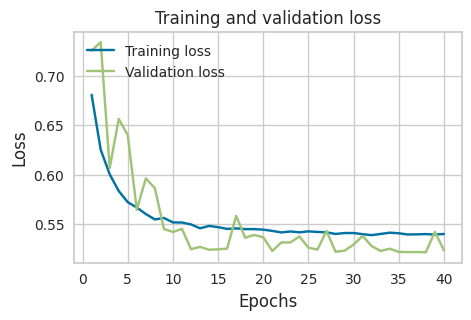

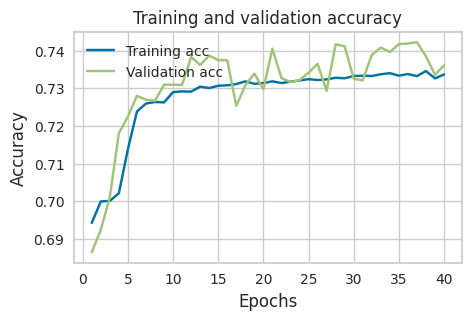

1988/1988 [==============================] - 1s 678us/step
              precision    recall  f1-score   support

           0       0.55      0.41      0.47     18873
           1       0.78      0.86      0.81     44734

    accuracy                           0.72     63607
   macro avg       0.66      0.63      0.64     63607
weighted avg       0.71      0.72      0.71     63607

Optimized threshold for best F1: 0.55


0.55

In [42]:
global_train_model(
    model=model,
    epochs=40,
    batch_size=batch_size,
    optimizer=optimizers.RMSprop(learning_rate=0.000001),
    loss=loss,
    metrics=metrics,
    f1_average='weighted')